In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


/Users/dave/miniconda3/envs/ernesto-gym/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from pathlib import Path

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator
from stable_baselines3 import PPO

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

In [31]:
folder = "./logs/ppo/models/"
prefix = 'ppo_new_norm_energy_weights_'

In [32]:
result_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(prefix)]

In [33]:
result_files

['ppo_new_norm_energy_weights_2500000_steps.zip',
 'ppo_new_norm_energy_weights_3000000_steps.zip',
 'ppo_new_norm_energy_weights_4000000_steps.zip',
 'ppo_new_norm_energy_weights_4500000_steps.zip',
 'ppo_new_norm_energy_weights_5000000_steps.zip',
 'ppo_new_norm_energy_weights_3500000_steps.zip',
 'ppo_new_norm_energy_weights_2000000_steps.zip',
 'ppo_new_norm_energy_weights_1500000_steps.zip',
 'ppo_new_norm_energy_weights_1000000_steps.zip',
 'ppo_new_norm_energy_weights_500000_steps.zip']

In [34]:
models = {file.split('.')[0]: folder + file for file in result_files[::2]}

In [35]:
models

{'ppo_new_norm_energy_weights_2500000_steps': './logs/ppo/models/ppo_new_norm_energy_weights_2500000_steps.zip',
 'ppo_new_norm_energy_weights_4000000_steps': './logs/ppo/models/ppo_new_norm_energy_weights_4000000_steps.zip',
 'ppo_new_norm_energy_weights_5000000_steps': './logs/ppo/models/ppo_new_norm_energy_weights_5000000_steps.zip',
 'ppo_new_norm_energy_weights_2000000_steps': './logs/ppo/models/ppo_new_norm_energy_weights_2000000_steps.zip',
 'ppo_new_norm_energy_weights_1000000_steps': './logs/ppo/models/ppo_new_norm_energy_weights_1000000_steps.zip'}

In [36]:
pack_options = "ernestogym/ernesto/data/battery/pack.yaml"
# ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_pack.yaml"
ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto/data/battery/models/thermal/r2c_thermal_pack.yaml"
bolun = "ernestogym/ernesto/data/battery/models/aging/bolun_pack.yaml"
# world = "ernestogym/envs/single_agent/world_deg.yaml"
world = "ernestogym/envs/single_agent/world_fading.yaml"

weights = {"trading_coeff": 0.7, "operational_cost_coeff": 0.1, "degradation_coeff": 0, "clip_action_coeff": 0.2}

params = parameter_generator(
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    reward_coeff=weights
)

# Create environment
env = MicroGridEnv(settings=params)

timestamps = env.demand.timestamps
num_steps = len(env.demand)

comparison_dict = {
    'actual_reward': {},
    'weighted_reward': {},
    'total_reward': {}
}

In [37]:
for label, file in models.items():
    model = PPO.load(file, env=env)

    actions = [] 
    vec_env = model.get_env()
    vec_env.set_options({'eval_profile': '70'})
    obs = vec_env.reset()
    for i in tqdm(range(num_steps)):
        action, _states = model.predict(obs)
        actions.append(action)
        obs, rewards, dones, info = vec_env.step(action)

    comparison_dict['total_reward'][label] = env.total_reward
    comparison_dict['actual_reward'][label] = env.actual_reward_list
    comparison_dict['weighted_reward'][label] = env.weighted_reward_list

profile:  70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525600/525600 [02:30<00:00, 3490.58it/s]


profile:  70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525600/525600 [02:26<00:00, 3590.51it/s]


profile:  70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525600/525600 [02:30<00:00, 3489.95it/s]


profile:  70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525600/525600 [02:34<00:00, 3401.39it/s]


profile:  70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525600/525600 [02:36<00:00, 3351.61it/s]


In [38]:
def cum_reward_comparison(sampling_rate=50):
    fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)

    for i, item in enumerate(comparison_dict['weighted_reward'].items()):
        key, values = item
        ax.plot(timestamps[::sampling_rate], np.cumsum([sum(r) for r in values])[::sampling_rate], label=key, color=plot_colors[i])
        ax.set(xlabel='Time', ylabel='Cumulative Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
    ax.legend()

def cum_reward_terms_comparison(sampling_rate=50):
    fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1, figsize=(9, 12), tight_layout=True, sharex=True)
    
    for i, item in enumerate(comparison_dict['actual_reward'].items()):
        key, values = item
        
        ax1.plot(timestamps[::sampling_rate], np.cumsum([r[0] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
        ax1.set(xlabel='Time', ylabel='Trading Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
          
        ax2.plot(timestamps[::sampling_rate], np.cumsum([r[1] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
        ax2.set(xlabel='Time', ylabel='Operational Cost Penalty', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
          
        ax3.plot(timestamps[::sampling_rate], np.cumsum([r[2] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
        ax3.set(xlabel='Time', ylabel='Degradation Penalty', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
          
        ax4.plot(timestamps[::sampling_rate], np.cumsum([r[3] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
        ax4.set(xlabel='Time', ylabel='Action Clipping Penalty', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        
    plt.legend()   
    
def single_policy_cum_reward_terms_comparison(sampling_rate=50, policy='ppo'):
    fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1, figsize=(9, 12), tight_layout=True, sharex=True)
    
    key, values = policy, comparison_dict['actual_reward'][policy]
    i = 0
        
    ax1.plot(timestamps[::sampling_rate], np.cumsum([r[0] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
    ax1.set(xlabel='Time', ylabel='Trading Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

    ax2.plot(timestamps[::sampling_rate], np.cumsum([r[1] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
    ax2.set(xlabel='Time', ylabel='Operational Cost Penalty', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

    ax3.plot(timestamps[::sampling_rate], np.cumsum([r[2] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
    ax3.set(xlabel='Time', ylabel='Degradation Penalty', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

    ax4.plot(timestamps[::sampling_rate], np.cumsum([r[3] for r in values])[::sampling_rate], label=key, color=plot_colors[i])
    ax4.set(xlabel='Time', ylabel='Action Clipping Penalty', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

    
def single_policy_plot_rewards_terms(rewards: list, policy='ppo'):
    nrows = 4
    ncols = 1
    labels = ['Trading', 'Operational Cost', 'Degradation', 'Action_clipping']
    
    values = rewards[policy]
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 12), tight_layout=True, sharex=True)
    
    for j in range(nrows):
        ax[j].plot(timestamps, np.array(values)[:, j], label='{} Reward'.format(labels[j]), color=plot_colors[j])
        ax[j].set(xlabel='Time', ylabel='{} Reward'.format(labels[j]), 
                  xticks=[timestamps[0], timestamps[len(timestamps)//2],timestamps[-1]])
        #ax[j].legend()
        
def average_cumulative_reward(rewards: list, policy='ppo'):
    fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, sharey=True)
    
    test_profiles = ['70', '71', '72', '73', '74']
    
    ax.plot(df_mean[idx].index, df_mean[idx][col], label='Winter', color='tab:blue')
    ax.fill_between(df_mean[idx].index, df_mean[idx][col] - df_std[idx][col], df_mean[idx][col] + df_std[idx][col], color='tab:blue', alpha=0.5)

    idx = 1
    ax.plot(df_mean[idx].index, df_mean[idx][col], label='Summer', color='tab:orange')
    ax.fill_between(df_mean[idx].index, df_mean[idx][col] - df_std[idx][col], df_mean[idx][col] + df_std[idx][col], color='tab:orange', alpha=0.5)

    ax.set(xlabel='Day Hours', ylabel='Average Demand (kWh)', xticks=df_mean[idx].index[::3])
    ax.legend()


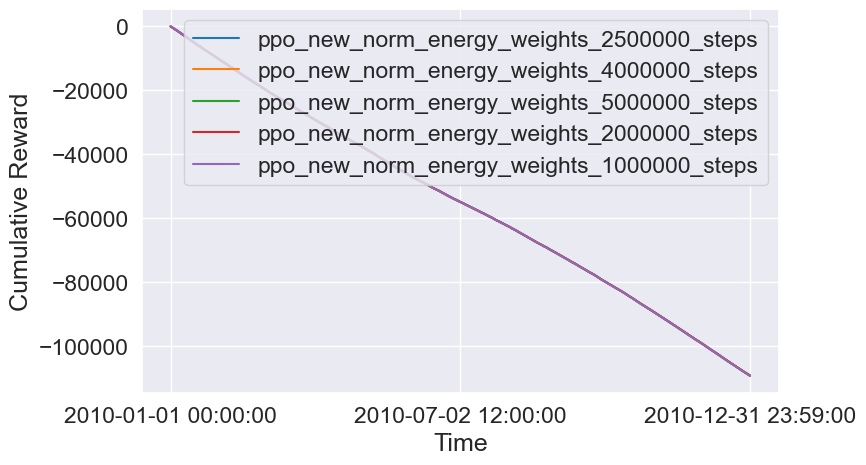

In [39]:
cum_reward_comparison()

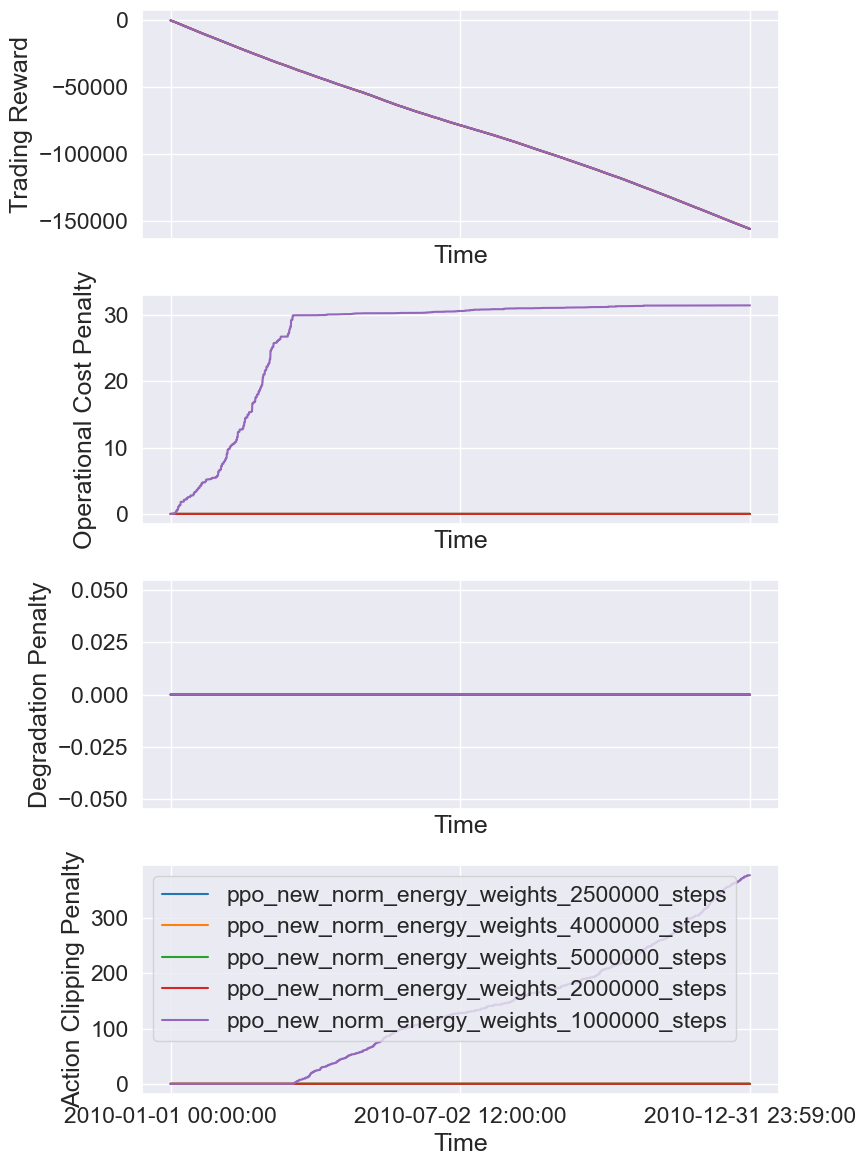

In [40]:
cum_reward_terms_comparison()

In [ ]:
single_policy_plot_rewards_terms(rewards=comparison_dict['weighted_reward'], policy='ppo_new_norm_energy_weights_1000000_steps')